# Biostat M280 Homework 2
# Sarah Ji
**Due May 11 @ 11:59PM**

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).
In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Later in the course we will learn how to derive a majorization-minimization (MM) algorithm with iterative updates
$$
	v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
	w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. Efficiency (both speed and memory) will be the most important criterion when grading this problem.


1. Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.
```julia
function nnmf(
    X::Matrix, 
    r::Int;
    maxiter::Int=1000, 
    tol::eltype(X)=1e-4,
    V::Matrix{eltype(X)}=rand(size(X, 1), r),
    W::Matrix{eltype(X)}=rand(r, size(X, 2))
    )
    # implementation
    # Output
    return V, W
end
```

0. Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  
Read in the [`nnmf-2429-by-361-face.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm()`](https://docs.julialang.org/en/stable/stdlib/io-network/#Base.DataFmt.readdlm-Tuple{Any,Char,Type,Char}) function, and display a couple sample images, e.g., using [ImageView.jl](https://github.com/JuliaImages/ImageView.jl) package.

0. Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/W0.txt)) and stopping criterion
$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

0. Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

0. (Optional) Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in part 2.

## Q1.1 Solution:

In [1]:
#using for loop
function nnmf(
    X::Matrix{T}, 
    r::Integer;
    maxiter::Integer=1000, 
    tol::Number=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    A_mul_B!(A, V, W)
    A .= X .- A
    l_last = abs2(vecnorm(A, 2))

    for i in 1:maxiter
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U', 'N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U', 'T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
        if (abs(l_new - l_last) / (abs(l_last) + 1)) <= tol
            break
        end
        l_last = l_new
    end
    
    return V, W
end

nnmf (generic function with 1 method)

In [34]:
#using for loop
function nnmfOneDemo(
    X::Matrix{T}, 
    r::Integer;
    maxiter::Integer=1000, 
    tol::Number=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    A_mul_B!(A, V, W)
    A .= X .- A
    l_last = abs2(vecnorm(A, 2))

    for i in 1:maxiter
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U', 'N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U', 'T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
        if (abs(l_new - l_last) / (abs(l_last) + 1)) <= tol
            println(i)
            break
        end
        l_last = l_new
    end
    
    return V, W
end

nnmfOneDemo (generic function with 1 method)

In [16]:
# using while loop
function nnmf2(
    X::Matrix{T}, 
    r::Integer;
    maxiter::Integer=1000, 
    tol::Number=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    #implementation
    m, n = size(X)
    A = zeros(X)
    MR_1 = zeros(m, r)
    MR_2 = zeros(m, r)
    RR = zeros(r, r)
    RN_1 = zeros(r, n)
    RN_2 = zeros(r, n)
    l_new = abs2(vecnorm(X - V * W, 2))
    l_last = 0.0
    count = 0
    
    while (abs(l_new - l_last) / (abs(l_last) + 1)) > tol && count < maxiter
        l_last = l_new
        count += 1
        
        A_mul_Bt!(MR_1, X, W)
        BLAS.syrk!('U','N', 1.0, W, 0.0, RR)
        V .= V .* MR_1 ./ BLAS.symm!('R', 'U', 1.0, RR, V, 0.0, MR_2)

        At_mul_B!(RN_1, V, X)
        BLAS.syrk!('U','T', 1.0, V, 0.0, RR)
        W .= W .* RN_1 ./ BLAS.symm!('L', 'U', 1.0, RR, W, 0.0, RN_2)

        A_mul_B!(A, V, W)
        A .= X .- A
        l_new = abs2(vecnorm(A, 2))
    end
    return V, W
end

nnmf2 (generic function with 1 method)

In [36]:
using BenchmarkTools
srand(1738)
@benchmark nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

BenchmarkTools.Trial: 
  memory estimate:  9.90 MiB
  allocs estimate:  22
  --------------
  minimum time:     13.366 s (0.00% GC)
  median time:      13.366 s (0.00% GC)
  mean time:        13.366 s (0.00% GC)
  maximum time:     13.366 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

## Q1.2 Solution:

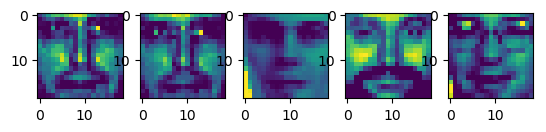

PyObject <matplotlib.image.AxesImage object at 0x13a597690>

In [2]:
#Pkg.add("ImageView")
using ImageView
using PyPlot

X = readdlm("nnmf-2429-by-361-face.txt")
img1 = X[1,:]
img1 = reshape(img1, 19, 19)
img2 = X[2,:]
img2 = reshape(img2, 19, 19)
img3 = X[10, :]
img3 = reshape(img3, 19, 19)
img4 = X[125, :]
img4 = reshape(img4, 19, 19)
img5 = X[130, :]
img5 = reshape(img5, 19, 19)

subplot(1, 5, 1)
PyPlot.imshow(img1)
subplot(1, 5, 2)
PyPlot.imshow(img2)
subplot(1, 5, 3)
PyPlot.imshow(img3)
subplot(1, 5, 4)
PyPlot.imshow(img4)
subplot(1, 5, 5)
PyPlot.imshow(img5)

## Q1.3 Solution:

In [5]:
V0 = readdlm("V0.txt");
W0 = readdlm("W0.txt");
# with rank 10 its blurrier than with rank 50 because we are capturing less information from the original X

@time nnmf(X, 10, V = V0[:, 1:10], W = W0[1:10, :])
@time nnmf(X, 20, V = V0[:, 1:20], W = W0[1:20, :])
@time nnmf(X, 30, V = V0[:, 1:30], W = W0[1:30, :])
@time nnmf(X, 40, V = V0[:, 1:40], W = W0[1:40, :])
@time nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

  9.353917 seconds (25 allocations: 7.331 MiB)
  5.326004 seconds (33 allocations: 7.972 MiB, 0.10% gc time)
  5.973540 seconds (25 allocations: 8.614 MiB)
  8.927220 seconds (25 allocations: 9.258 MiB)
 13.341827 seconds (26 allocations: 9.903 MiB, 0.04% gc time)


([4.06515e-8 0.0239183 … 0.00502753 0.0308952; 2.06692e-5 0.0167692 … 0.00168436 0.0335739; … ; 0.0136536 0.0204076 … 8.933e-5 0.0451226; 0.0182157 0.00994188 … 5.39374e-6 0.000142989], [1.98839e-64 1.24767e-53 … 2.73192e-14 8.87992e-65; 5.00853e-27 2.38036e-26 … 2.00588e-32 4.48034e-61; … ; 3.60097e-15 2.70773e-15 … 3.86231e-22 2.41101e-44; 0.000249871 6.68716e-20 … 2.36259e-7 1.30468e-11])

## Q1.4 Solution:

For r = 50, we do not obtain the same objective value and (V, W) are not the same from that of Q1.3.

In [7]:
V_50, W_50 = nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])
V_r, W_r = nnmf(X, 50)
@show V_50 == V_r
@show W_50 == W_r

V_r == V_50 = false
W_50 == W_r = false


false

In [14]:
@show L_50 = abs2(vecnorm((X - (V_50 * W_50)), 2))
@show L_random = abs2(vecnorm((X - (V_r * W_r)), 2))

L_50 = abs2(vecnorm(X - V_50 * W_50, 2)) = 4430.201581697289
L_random = abs2(vecnorm(X - V_r * W_r, 2)) = 4494.235190193085


4494.235190193085

## Q1.5 Solution:


In [36]:
V_ones = ones(2429, 50)
W_ones = ones(50, 361)
V_1, W_1 = nnmf(X, 50, V = V_ones, W = W_ones)

@show V_50 == V_1
@show W_50 == W_1

VW_1 = V_1*W_1 # like our new X for initial values 1
VW_50 = V_50*W_50 # X = VW with first 50 columns and 50 rows 

@show L_one = abs2(vecnorm((X - (V_1 * W_1)), 2))
@show L_50 = abs2(vecnorm((X - (V_50 * W_50)), 2))

V_50 == V_1 = false
W_50 == W_1 = false
L_one = abs2(vecnorm(X - V_1 * W_1, 2)) = 25297.01651108185
L_50 = abs2(vecnorm(X - V_50 * W_50, 2)) = 4430.201581697289


4430.201581697289

In [35]:
nnmfOneDemo(X, 50, V = V_ones, W = W_ones)

1


([0.00547467 0.00547467 … 0.00547467 0.00547467; 0.00544139 0.00544139 … 0.00544139 0.00544139; … ; 0.00570408 0.00570408 … 0.00570408 0.00570408; 0.00560619 0.00560619 … 0.00560619 0.00560619], [0.369952 0.46066 … 0.558078 0.42552; 0.369952 0.46066 … 0.558078 0.42552; … ; 0.369952 0.46066 … 0.558078 0.42552; 0.369952 0.46066 … 0.558078 0.42552])

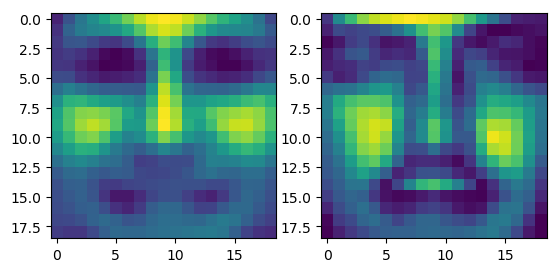

PyObject <matplotlib.image.AxesImage object at 0x12e150490>

In [37]:
subplot(1, 2, 1)
PyPlot.imshow(reshape(VW_1[5, :], 19, 19))
subplot(1, 2, 2)
PyPlot.imshow(reshape(VW_50[1, :], 19, 19))

When we give the initial values of ones, it stops after only one iteration, because the updates for V and W will be close to the last due to mean and variance of the original X matrix given. 

Note that when we plot the rows of the VW_1, we only get one face. That is, each row contains data which maps to the same one person's face. 

## Q1.6 Solution:

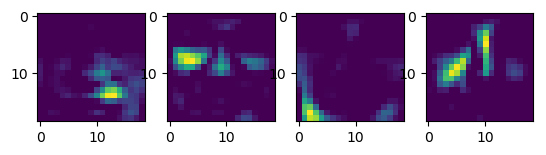

PyObject <matplotlib.image.AxesImage object at 0x12e476d50>

In [17]:
V, W = nnmf(X, 50, V = V0[:, 1:50], W = W0[1:50, :])

W_img1 = W[1, :]
W_img1 = reshape(W_img1, 19, 19)

W_img2 = W[2, :]
W_img2 = reshape(W_img2, 19, 19)

W_img5 = W[5, :]
W_img5 = reshape(W_img5, 19, 19)

W_img10 = W[10, :]
W_img10 = reshape(W_img10, 19, 19)

#VW = V*W
subplot(1, 4, 1)
PyPlot.imshow(W_img1)
subplot(1, 4, 2)
PyPlot.imshow(W_img2)
subplot(1, 4, 3)
PyPlot.imshow(W_img5)
subplot(1, 4, 4)
PyPlot.imshow(W_img10)

## Q2. Linear Mixed Models

Consider a linear mixed effects model
$$
	y_i = \mathbf{x}_i^T \beta + \mathbf{z}_i^T \gamma + \epsilon_i, \quad i=1,\ldots,n,
$$
where $\epsilon_i$ are independent normal errors $N(0,\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\gamma \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. 

0. Show that 
$$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$
where $\mathbf{y} = (y_1, \ldots, y_n)^T \in \mathbb{R}^n$, $\mathbf{X} = (\mathbf{x}_1, \ldots, \mathbf{x}_n)^T \in \mathbb{R}^{n \times p}$, and $\mathbf{Z} = (\mathbf{z}_1, \ldots, \mathbf{z}_n)^T \in \mathbb{R}^{n \times q}$. 

0. Write a function, with interface 
    ```julia
    logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number),
    ```
that evaluates the log-density of a multivariate normal with mean $\mathbf{0}$ and covariance $\sigma_0^2 \mathbf{I} + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T$ at $\mathbf{y}$. Make your code efficient in the $n \gg q$ case. 

0. Compare your result (both accuracy and timing) to the [Distributions.jl](http://distributionsjl.readthedocs.io/en/latest/multivariate.html#multivariate-normal-distribution) package using following data.  
    ```julia
    using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn(y, Z, σ0, σ1)
    @show logpdf(mvn, y)

    # benchmark
    @benchmark logpdf_mvn(y, Z, σ0, σ1)
    @benchmark logpdf(mvn, y)
    ```

## Q2.1 Solution:

${f(y) = \frac1{sqrt(2\pi))^p|\mathbf{\Sigma}|^{1/2}}}$ * $e^{-(y-\mathbf{\mu})^{T}\Sigma^{-1}(y-\mu)/2}$ 
<br>
>Take the log of both sides to get the log pdf:

$$log(f(y)) =  \frac{-p}{2}log(2\pi) - \frac{-1}{2}log|\mathbf{\Sigma}| - \frac{[(y-\mu)^T\mathbf{\Sigma}^{-1}(y-\mu)]}{2}$$
<br>

>Now, we use the Woodbury Formula. Let $\mathbf{A} = \sigma_0^{2}I_n$ and $\mathbf{U} = \mathbf{V} = \sigma_1\mathbf{Z}$
<br>
Using the Woodbury Formula and properties of determinants of block matrices, we can plug in $\mathbf{|\Sigma|}$ and  $\mathbf{\Sigma^{-1}}$. 
<br>

In [11]:
# better memory efficiency
function logpdf_mvn0(y::Vector, Z::Matrix, σ0::Number, σ1::Number)
    n = length(y)
    Σchol = cholfact!(σ1^2/σ0^2 * (Z' * Z) + I) 
    logdetΣchol = 2 * n * log(σ0) + logdet(Σchol)
    - (n//2) * log(2π) - (1//2) * logdetΣchol - (1//2) * (sum(abs2, y)/σ0^2 - sum(abs2, Σchol[:L] \ ((Z' * y) * (σ1/σ0^2))))
end

logpdf_mvn0 (generic function with 1 method)

In [12]:
# better memory efficiency
function logpdf_mvn1(y::Vector, Z::Matrix, σ0::Number, σ1::Number)
    n = length(y)
    Σchol = cholfact(σ1^2/σ0^2 * Symmetric(BLAS.syrk('U', 'T', 1, Z)) + I) 
    #cholesky factorization works really fast on symmetric matrices
    logdetΣchol = 2 * n * log(σ0) + logdet(Σchol)
    - (n//2) * log(2π) - (1//2) * logdetΣchol - (1//2) * (sum(abs2, y)/σ0^2 - sum(abs2, Σchol[:L] \ ((Z' * y) * (σ1/σ0^2))))
end

logpdf_mvn1 (generic function with 1 method)

In [13]:
Symmetric(BLAS.syrk('U', 'T', 1, Z))

LoadError: [91mUndefVarError: Z not defined[39m

In [14]:
# better memory efficiency
function logpdf_mvn2(y::Vector, Z::Matrix, σ0::Number, σ1::Number)
    n = length(y)
    Σchol = cholfact(σ1^2 * Z * Z.' + σ0^2 * I)
    - (n//2) * log(2π) - (1//2) * logdet(Σchol) - (1//2) * dot(y, Σchol \ y)
end

logpdf_mvn2 (generic function with 1 method)

In [15]:
using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn0(y, Z, σ0, σ1)
    @show logpdf_mvn1(y, Z, σ0, σ1)
 @show logpdf_mvn2(y, Z, σ0, σ1)    
@show logpdf(mvn, y)

logpdf_mvn0(y, Z, σ0, σ1) = -1571.5736734653365
logpdf_mvn1(y, Z, σ0, σ1) = -1571.5736734653365
logpdf_mvn2(y, Z, σ0, σ1) = -1571.5736734654133
logpdf(mvn, y) = -1571.5736734654135


-1571.5736734654135

In [16]:
# benchmark
@benchmark logpdf_mvn0(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  4.17 KiB
  allocs estimate:  16
  --------------
  minimum time:     36.658 μs (0.00% GC)
  median time:      37.224 μs (0.00% GC)
  mean time:        38.693 μs (0.82% GC)
  maximum time:     1.673 ms (95.11% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [17]:
# benchmark
@benchmark logpdf_mvn1(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  5.11 KiB
  allocs estimate:  19
  --------------
  minimum time:     36.601 μs (0.00% GC)
  median time:      37.287 μs (0.00% GC)
  mean time:        38.862 μs (0.85% GC)
  maximum time:     1.756 ms (94.88% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [18]:
@benchmark logpdf_mvn2(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  91.87 MiB
  allocs estimate:  19
  --------------
  minimum time:     176.886 ms (6.88% GC)
  median time:      217.874 ms (8.78% GC)
  mean time:        223.558 ms (11.20% GC)
  maximum time:     380.577 ms (44.16% GC)
  --------------
  samples:          23
  evals/sample:     1

In [19]:
@benchmark logpdf(mvn, y)

BenchmarkTools.Trial: 
  memory estimate:  15.78 KiB
  allocs estimate:  3
  --------------
  minimum time:     3.822 ms (0.00% GC)
  median time:      6.362 ms (0.00% GC)
  mean time:        6.092 ms (0.00% GC)
  maximum time:     8.131 ms (0.00% GC)
  --------------
  samples:          818
  evals/sample:     1